## Py-DDA example notebook

This notebooks shows how you can get multiple Doppler winds from different radars. 

The PyDDA package is built on top of Py-ART. Therefore, Py-ART is needed for PyDDA to run. 

用于多雷达反演风场的程序，pydda支持的数据源是cfradial格式，我们这里直接将FMT标准格式数据解析，然后转码成cfradial格式，再调用

In [1]:
%matplotlib inline
import pyart
import pydda
import warnings
import matplotlib.pyplot as plt
from metradar.io.decode_fmt_pyart import read_cnrad_fmt
from metradar.util.get_tlogp_from_sharppy import get_profile
import numpy as np
import xarray as xr
# warnings.filterwarnings("ignore")
print('PyDDA version:',pydda.__version__)



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



2026-01-15 21:34:17.053791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Welcome to PyDDA 2.2
If you are using PyDDA in your publications, please cite:
Jackson et al. (2020) Journal of Open Research Science
Detecting Jax...
Jax/JaxOpt are not installed on your system, unable to use Jax engine.
Detecting TensorFlow...
TensorFlow detected. Checking for tensorflow-probability...
TensorFlow-probability detected. TensorFlow engine enabled!
PyDDA version: 2.2


First, we load our Cf-Compliant grids using Py-ART's read_grid function.

In [2]:
rootpath = '/mnt/e/metradar_test/wind_retrieve'
radarfiles=[]
radarfiles.append(rootpath + '/basedata/淮安/Z_RADR_I_Z9517_20200612053920_O_DOR_SA_CAP_FMT.bin.bz2')
radarfiles.append(rootpath + '/basedata/南京/Z_RADR_I_Z9250_20200612054229_O_DOR_SAD_CAP_FMT.bin.bz2')
radarfiles.append(rootpath + '/basedata/泰州/Z_RADR_I_Z9523_20200612054032_O_DOR_SA_CAP_FMT.bin.bz2')

# 调用read_cnrad_fmt函数读取FMT格式基数据

radar_objs = [read_cnrad_fmt(radarfile) for radarfile in radarfiles]


In [3]:
# 进行速度退模糊处理

for radar in radar_objs:
    newvel = pyart.correct.dealias_region_based(radar, vel_field='velocity')
    radar.add_field('corrected_velocity', newvel, replace_existing=True)


In [4]:
print(radar_objs[0].info())


altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (4045,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (4045,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	spectrum_width:
		data: <ndarray of type: float32 and shape: (4045, 1841)>
		units: meters_per_second
		standard_name: doppler_spectrum_width
		long_name: Spectrum Width
		valid_max: 63.0
		valid_min: -63.5
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	reflectivity:
		data: <ndarray of typ

In [4]:
grid_objs=[]

# 设置组网参数
standard_lat = 32.5
standard_lon = 119.4
xreso = 1000  # 单位m
yreso = 1000  # 单位m
zreso = 500   # 单位m
xlims = ( -50,  50)  # 单位km
ylims = ( -25,  75)  # 单位km
zlims = (  1,  15)  # 单位km

g_xlim = (xlims[0]*1000,xlims[1]*1000)
g_ylim = (ylims[0]*1000,ylims[1]*1000)
g_zlim = (zlims[0]*1000,zlims[1]*1000)
g_numx = int(len(range(xlims[0],xlims[1]))*1000/xreso+1) # x方向格点数
g_numy = int(len(range(ylims[0],ylims[1]))*1000/yreso+1) # y方向格点数
g_numz = int(len(range(zlims[0],zlims[1]))*1000/zreso+1) # z方向格点数
# 调用pyart的grid函数，将极坐标格式雷达基数据转换为格点格式，并以xarray格式保存
for nn in range(len(radar_objs)):
    grid_objs.append(pyart.map.grid_from_radars(
                (radar_objs[nn],),
                grid_origin=[standard_lat,standard_lon],
                weighting_function = 'BARNES2',
                grid_shape=(g_numz, g_numy, g_numx),
                grid_limits=(g_zlim, g_ylim, g_xlim),
                fields=['reflectivity','velocity','corrected_velocity']).to_xarray())

In [5]:

# 按z，y，x的顺序，进行meshgrid
point_z,point_y,point_x = np.mgrid[
    g_zlim[0]:g_zlim[1]+zreso:zreso,
    g_ylim[0]:g_ylim[1]+yreso:yreso,
    g_xlim[0]:g_xlim[1]+xreso:xreso
]

# 将point_x, point_y, point_z添加到grid对象中
for nn in range(len(grid_objs)):
    grid_objs[nn]['point_x'] = (('z','y','x'), point_x)
    grid_objs[nn]['point_y'] = (('z','y','x'), point_y)
    grid_objs[nn]['point_z'] = (('z','y','x'), point_z)

# 根据z，y，x坐标，计算对应的方位角和仰角，并存储在AZ变量和EL变量中
for nn in range(len(grid_objs)):
    grid_objs[nn]['AZ'] = (('z','y','x'), pyart.core.cartesian_to_antenna(
        grid_objs[nn]['point_x'].data,
        grid_objs[nn]['point_y'].data,
        grid_objs[nn]['point_z'].data)[1])
    grid_objs[nn]['EL'] = (('z','y','x'), pyart.core.cartesian_to_antenna(
        grid_objs[nn]['point_x'].data,
        grid_objs[nn]['point_y'].data,
        grid_objs[nn]['point_z'].data)[2])
# 将高度信息存储在point_altitude变量中,直接采用z坐标值
for nn in range(len(grid_objs)):
    grid_objs[nn]['point_altitude'] = (('z','y','x'), grid_objs[nn]['point_z'].data)


In [6]:
print(grid_objs[0].point_altitude)

<xarray.DataArray 'point_altitude' (z: 29, y: 101, x: 101)> Size: 2MB
array([[[ 1000,  1000,  1000, ...,  1000,  1000,  1000],
        [ 1000,  1000,  1000, ...,  1000,  1000,  1000],
        [ 1000,  1000,  1000, ...,  1000,  1000,  1000],
        ...,
        [ 1000,  1000,  1000, ...,  1000,  1000,  1000],
        [ 1000,  1000,  1000, ...,  1000,  1000,  1000],
        [ 1000,  1000,  1000, ...,  1000,  1000,  1000]],

       [[ 1500,  1500,  1500, ...,  1500,  1500,  1500],
        [ 1500,  1500,  1500, ...,  1500,  1500,  1500],
        [ 1500,  1500,  1500, ...,  1500,  1500,  1500],
        ...,
        [ 1500,  1500,  1500, ...,  1500,  1500,  1500],
        [ 1500,  1500,  1500, ...,  1500,  1500,  1500],
        [ 1500,  1500,  1500, ...,  1500,  1500,  1500]],

       [[ 2000,  2000,  2000, ...,  2000,  2000,  2000],
        [ 2000,  2000,  2000, ...,  2000,  2000,  2000],
        [ 2000,  2000,  2000, ...,  2000,  2000,  2000],
        ...,
...
        [14000, 14000, 14000

In [7]:
profile = get_profile('/mnt/e/metradar_test/wind_retrieve/tlogp/','20061208.58238')
print('探空数据加载完毕！')

profile read over!
探空数据加载完毕！


### 接下来，从探空数据中提取风廓线数据作为初始场

In [8]:
# 从探空中获取初始场
grid_objs[0]= pydda.initialization.make_wind_field_from_profile(
        grid_objs[0], profile, vel_field='corrected_velocity')



### 接下来，真正的风场反演开始，如果要使用tenserflow进行计算，请确保以下库已安装
* !pip install tensorflow
* !pip install tensorflow-probability
* !pip install tf_keras

In [9]:
Grids, _ = pydda.retrieval.get_dd_wind_field(
    grid_objs,
    Co=100.0,
    Cm=1500.0,
    Cx=1e-2,
    Cy=1e-2,
    Cz=1e-2,
    vel_name="corrected_velocity",
    refl_field="reflectivity",
    frz=5000.0,
    engine="tensorflow", # 有GPU就用tensorflow，没有就用scipy或jax
    mask_outside_opt=True,
    upper_bc=1,
)

W0000 00:00:1768484100.766823   60450 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Calculating weights for radars 0 and 1
Calculating weights for radars 0 and 2
Calculating weights for radars 1 and 0
Calculating weights for radars 1 and 2
Calculating weights for radars 2 and 0
Calculating weights for radars 2 and 1
Calculating weights for models...
Points from Radar 0: 82537
Points from Radar 1: 98628
Points from Radar 2: 83856
Starting solver 
rmsVR = 10.458288
Total points: 265021
The max of w_init is 0.0
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|20861676.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the cost functions is 10.709668
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10|16518450.0000| 341.1342|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   8.1545
The gradient of the cost functions is 13.818824
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20|16518464.0000| 123.93

### 如果要使用tensorflow引擎，请确保已安装以下库：

In [10]:
#计算拉伸涡度和倾斜涡度
def calc_vortex(Grids):
    # 默认Grids的维度是time,z,y,x四维
    
    if isinstance(Grids, list):
        uwind=Grids[0]['u'].values
        vwind=Grids[0]['v'].values
        wwind=Grids[0]['w'].values
    else:
        uwind=Grids['u'].values
        vwind=Grids['v'].values
        wwind=Grids['w'].values
    # 检查uwind的维度是否是四维
    if uwind.ndim != 4:
        raise ValueError("Expected uwind to be a 4D array with dimensions (time, z, y, x)")
    
    vor_stretch_data = np.zeros(uwind.shape,dtype=float)
    vor_tilt_data = np.zeros(uwind.shape,dtype=float)
    for tt in range(uwind.shape[0]):
        dudz,dudy,dudx = np.gradient(uwind[tt,:,:,:])
        dvdz,dvdy,dvdx = np.gradient(vwind[tt,:,:,:])
        dwdz,dwdy,dwdx = np.gradient(wwind[tt,:,:,:])
        
        for lev in range(uwind.shape[1]):
            # picname="stretch_%03d.png"%lev
            # print(lev)
            
            div=dudx[lev,:,:] + dvdy[lev,:,:]
            vor=dvdx[lev,:,:] - dudy[lev,:,:]
            
            u=uwind[tt,lev,:,:]
            v=vwind[tt,lev,:,:]
            #dw
            
            #拉伸项
            vor_stretch_data[tt,lev,:,:]=vor*div

            #倾斜项
            vor_tilt_data[tt,lev,:,:]=dwdy[lev,:,:]*dudz[lev,:,:]-dwdx[lev,:,:]*dvdz[lev,:,:]


    if isinstance(Grids, list):
        for nn in range(len(Grids)):
            Grids[nn]['vor_stretch'] = (('time','z','y','x'), vor_stretch_data)
            Grids[nn]['vor_tilt'] = (('time','z','y','x'), vor_tilt_data)
            
            # add attrs
            
            Grids[nn]['vor_stretch'].attrs['long_name'] = 'stretch vortex'
            Grids[nn]['vor_stretch'].attrs['units'] = 'm-2/s-2'
            Grids[nn]['vor_stretch'].attrs['coordinates'] = 't,z,y,x'
            
            Grids[nn]['vor_tilt'].attrs['long_name'] = 'tilting vortex'
            Grids[nn]['vor_tilt'].attrs['units'] = 'm-2/s-2'
            Grids[nn]['vor_tilt'].attrs['coordinates'] = 't,z,y,x'
        
    else:
        Grids['vor_stretch'] = (('time','z','y','x'), vor_stretch_data)
        Grids['vor_tilt'] = (('time','z','y','x'), vor_tilt_data)
        Grids['vor_stretch'].attrs['long_name'] = 'stretch vortex'
        Grids['vor_stretch'].attrs['units'] = 'm-2/s-2'
        Grids['vor_stretch'].attrs['coordinates'] = 't,z,y,x'
        
        Grids['vor_tilt'].attrs['long_name'] = 'tilting vortex'
        Grids['vor_tilt'].attrs['units'] = 'm-2/s-2'
        Grids['vor_tilt'].attrs['coordinates'] = 't,z,y,x'
    

    return Grids


calc_vortex(Grids)
print('涡度计算完成')

涡度计算完成


### 保存反演后的数据

In [12]:
for nn in range(len(Grids)):
    # 将reflectivity小于10的格点设置为缺省值
    Grids[nn]['reflectivity'] = Grids[nn]['reflectivity'].where(Grids[nn]['reflectivity']>=10)
    Grids[nn].to_netcdf(radarfiles[nn]+ '_wind.nc')

### 重新加载数据

In [13]:
Grids = [
    xr.open_dataset(radarfile + '_wind.nc') for radarfile in radarfiles
]

### 绘图，针对不同角度进行绘图，包括水平、垂直剖面

<Axes: title={'center': 'PyDDA retreived winds @1.5 km'}, xlabel='X [km]', ylabel='Y [km]'>

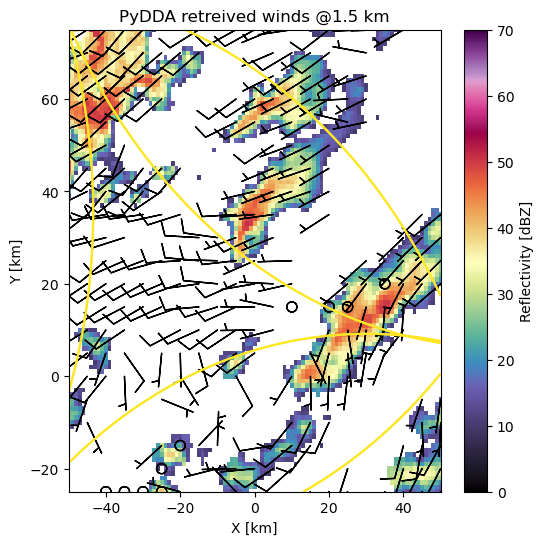

In [14]:
plt.figure(figsize=(6, 6))
pydda.vis.plot_horiz_xsection_barbs(
    Grids,
    None,
    "reflectivity",
    level=1,
    w_vel_contours=[3, 6, 9],
    barb_spacing_x_km=5.0,
    barb_spacing_y_km=5.0,
)

In [15]:
import math
def rad(d):
    return d * np.pi / 180.0
    
def getDistance(lat1, lng1, lat2, lng2):
    # 计算两点间的距离，单位为千米
    EARTH_REDIUS = 6378.137
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2), 2) + math.cos(radLat1) * math.cos(radLat2) * math.pow(math.sin(b/2), 2)))
    s = s * EARTH_REDIUS
    return s

In [16]:
# 垂直剖面分析的经度线和纬度线坐标，单位为度，最好精确到小数点后三位
ana_lat=32.787
ana_lon=119.376
s_x = getDistance(ana_lat,ana_lon,ana_lat,standard_lon)
s_y = getDistance(ana_lat,ana_lon,standard_lat,ana_lon)
lev_yz = int((xlims[0] - s_x)/(xreso/1e3))
lev_xz = int((s_y- ylims[0])/(yreso/1e3))

<Axes: title={'center': 'PyDDA retreived winds @31.0 km north of origin.'}, xlabel='X [km]', ylabel='Z [km]'>

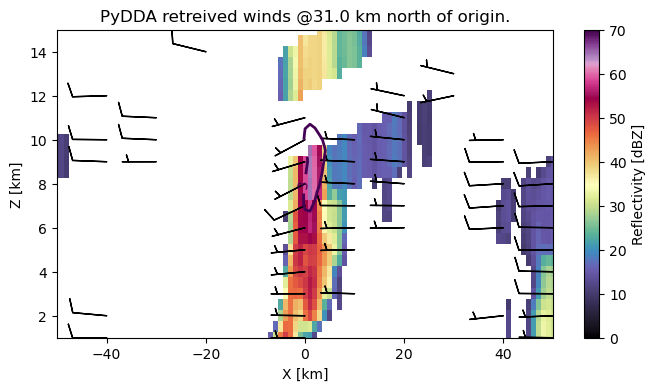

In [17]:
plt.figure(figsize=(8, 4))
pydda.vis.plot_xz_xsection_barbs(
    Grids,
    None,
    "reflectivity",
    level=lev_xz,
    w_vel_contours=[3, 6, 9],
    barb_spacing_x_km=10.0,
    barb_spacing_z_km=2.0,
)

<Axes: title={'center': 'PyDDA retreived winds @1.0 km west of origin.'}, xlabel='Y [km]', ylabel='Z [km]'>

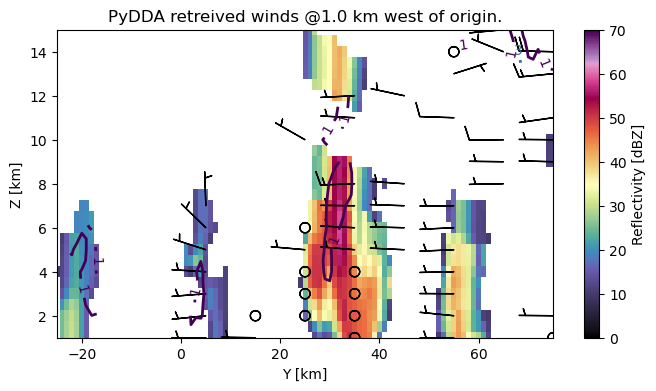

In [18]:
plt.figure(figsize=(8, 4))
pydda.vis.plot_yz_xsection_barbs(
    Grids,
    None,
    "reflectivity",
    level=lev_yz,
    w_vel_contours=[1, 3, 5, 7],
    barb_spacing_y_km=10.0,
    barb_spacing_z_km=2.0,
)

<Axes: title={'center': 'PyDDA retreived winds @2.0 km'}, xlabel='X [km]', ylabel='Y [km]'>

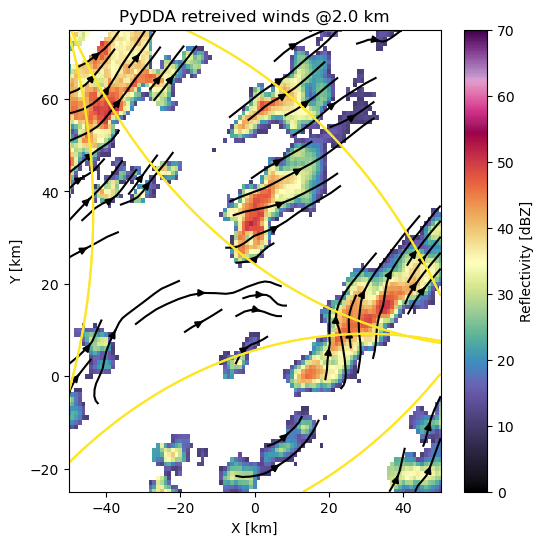

In [19]:
plt.figure(figsize=(6, 6))
pydda.vis.plot_horiz_xsection_streamlines(
    Grids,
    None,
    "reflectivity",
    level=2,
    w_vel_contours=[3, 6, 9],
)

(0.0, 15.0)

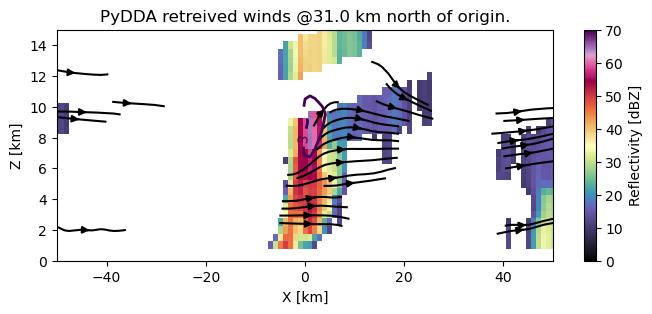

In [20]:
plt.figure(figsize=(8, 3))
pydda.vis.plot_xz_xsection_streamlines(
    Grids, None, "reflectivity", level=lev_xz, w_vel_contours=[3, 6, 9]
)
plt.ylim([0, 15])

<Axes: title={'center': 'PyDDA retreived winds @50.0 km west of origin.'}, xlabel='Y [km]', ylabel='Z [km]'>

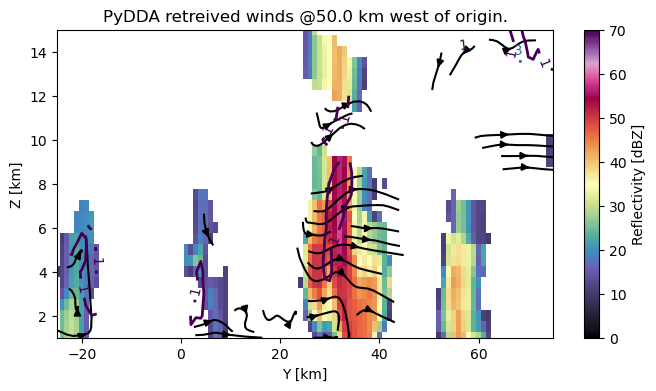

In [21]:
plt.figure(figsize=(8, 4))
pydda.vis.plot_yz_xsection_streamlines(
    Grids,
    None,
    "reflectivity",
    level=lev_yz,
    w_vel_contours=[1, 3, 5, 7],
)